In [1]:
#global variable
doNormalization=True

In [2]:
import numpy as np
import torch

def getValueByLable(lableList,valueList):
    """
    For instance, given a lable list ['Local_X','Local_Y'] and a value list [2.0, 24.0, 437.0, 1118846981300.0, 16.254, 
    79.349, 6451167.199, 1873312.382, 14.5, 4.9, 2.0, 39.14, -5.73, 2.0, 0.0, 13.0, 0.0, 0.0] which values sorted by the 
    order of allLableList below, the function return a value Dict {'Local_X':16.254, 'Local_Y':79.349}
    Args:
        lableList: the list of lables you've required, such as['Vehicle_ID', 'Total_Frames','Global_Time']
        valueList: the list contains all legally value, sorted by:['Vehicle_ID', 'Frame_ID','Total_Frames','Global_Time','Local_X','Local_Y','Global_X','Global_Y',\
                      'v_Length','v_Width','v_Class','v_Vel','v_Acc','Lane_ID','Preceding','Following','Space_Headway',\
                      'Time_Headway']
    Returns: 
        value dict of the input lables
    For instance, given a lable list ['Local_X','Local_Y'] and a value list [2.0, 24.0, 437.0, 1118846981300.0, 16.254, 
    79.349, 6451167.199, 1873312.382, 14.5, 4.9, 2.0, 39.14, -5.73, 2.0, 0.0, 13.0, 0.0, 0.0] which values sorted by the 
    order of allLableList above, the function return a value List [16.254, 79.349]

    """
    allLableList=['Vehicle_ID', 'Frame_ID','Total_Frames','Global_Time','Local_X','Local_Y','Global_X','Global_Y',\
                  'v_Length','v_Width','v_Class','v_Vel','v_Acc','Lane_ID','Preceding','Following','Space_Headway',\
                  'Time_Headway']
    valueDictReturn={}
    for lableItem in lableList:
        valueDictReturn[lableItem]=valueList[allLableList.index(lableItem)]
    return valueDictReturn

def rearrangeDataByGlobalTime(allValueLists):
    '''
    Args:
        allValueLists: all values have been read from a txt file which have already been converted to a list
    Returns:
        dict have been arranged by global time. One single global time generally contains several value lists.
    '''
    valueDict={}
    for valueList in allValueLists:
        dictKey=getValueByLable(['Global_Time'],valueList)['Global_Time']
        if dictKey in valueDict:
            # if dictKey already there, then add valueList to the list of the key
            valueDict[dictKey].append(valueList)
        else:
            #else, create a list and append valueList on it
            valueDict[dictKey]=[valueList]
    return valueDict

In [3]:
import copy

def readFirstFrame(matrixIndexAndVehicleIDRecordDictParam, valueLists):
    """
    To generate the first set of tensors from the first frame
    Args:
        matrixIndexAndVehicleIDRecordDictParam: just as its name
        valueLists: a list consists of all valuelist at one time
    Returns:
        several tensors arranged by: positionTensor, speedTensor, accTensor, angleTensor,newVehicleList(type:list)
    
    """
    maxMatrixIndex=matrixIndexAndVehicleIDRecordDictParam.keys().__len__()-1
    #tensors initialize
    positionTensor=torch.zeros(2,maxMatrixIndex)
    speedTensor=torch.zeros(1,maxMatrixIndex)
    accTensor=torch.zeros(1,maxMatrixIndex)
    angleTensor=torch.zeros(1,maxMatrixIndex)
    newVehicleIDList=[]
    curMatrixIndex=0
    matrixIndexAndVehicleIDRecordDictParam['time']=getValueByLable(["Global_Time"],valueLists[0])['Global_Time']
    #fill out all tensors
    for eachValueList in valueLists:
        #get values from eachValueList, generate dict
        returnedEachValueDict=getValueByLable(['Vehicle_ID','Local_X','Local_Y','v_Vel','v_Acc'],eachValueList)
        #assign to the curMatrixIndex-th row of corresponding tensor
        #angle Tensor assignment is not neeed for the initial value of each element in it is already zero
        positionTensor[:,curMatrixIndex]=torch.tensor((returnedEachValueDict['Local_X'],returnedEachValueDict['Local_Y']))
        speedTensor[:,curMatrixIndex]=torch.tensor((returnedEachValueDict['v_Vel']))
        accTensor[:,curMatrixIndex]=torch.tensor((returnedEachValueDict['v_Acc']))
        #then handle the record matrix
        matrixIndexAndVehicleIDRecordDictParam[curMatrixIndex]['Vehicle_ID']=returnedEachValueDict['Vehicle_ID']
        matrixIndexAndVehicleIDRecordDictParam[curMatrixIndex]['refresh']=0
        newVehicleIDList.append(copy.deepcopy(returnedEachValueDict['Vehicle_ID']))
        curMatrixIndex=curMatrixIndex+1
    return positionTensor,speedTensor,accTensor,angleTensor,newVehicleIDList

In [4]:
def findMatrixIndexByVehicleID(matrixIndexAndVehicleIDRecordDictParam, vehicle_ID):
    for i in range(0, len(matrixIndexAndVehicleIDRecordDictParam)-1):
        if matrixIndexAndVehicleIDRecordDictParam[i]['Vehicle_ID']==vehicle_ID:
            return i
    return -1

def findEmptyMatrixIndex(matrixIndexAndVehicleIDRecordDictParam):
    for i in range(0, len(matrixIndexAndVehicleIDRecordDictParam)-1):
        if matrixIndexAndVehicleIDRecordDictParam[i]['Vehicle_ID']==-1:
            #Vehicle_ID=-1 when there is no existed vehicle ID bounding to the index
            return i
    raise Exception("NO EMPTY ELEMENT IN MATRIX")

def readGeneralFrame(matrixIndexAndVehicleIDRecordDictParam, valueLists, prePositionTensor):
    """
    To generate the first set of tensors from the general frame that have a preceding one
    Args:
        matrixIndexAndVehicleIDRecordDictParam: just as its name
        valueLists: a list consists of all valuelist at one time
        prePositionTensor: positionTensor from the preceding frame, which is used to calculate angle tensor
    Returns:
        everal tensors arranged by: positionTensor, speedTensor, accTensor, angleTensor,newVehicleList(type:list),
        vanishedVehicleList(type:list)
    
    """
    #tensors initialize
    maxMatrixIndex=matrixIndexAndVehicleIDRecordDictParam.keys().__len__()-1
    positionTensor=torch.zeros(2,maxMatrixIndex)
    speedTensor=torch.zeros(1,maxMatrixIndex)
    accTensor=torch.zeros(1,maxMatrixIndex)
    angleTensor=torch.zeros(1,maxMatrixIndex)
    newVehicleIDList=[]
    vanishedVehicleList=[]
    curMatrixIndex=0
    matrixIndexAndVehicleIDRecordDictParam['time']=getValueByLable(["Global_Time"],valueLists[0])['Global_Time']
    #fill out all tensors
    for eachValueList in valueLists:
        #get values from eachValueList, generate dict
        returnedEachValueDict=getValueByLable(['Vehicle_ID','Local_X','Local_Y','v_Vel','v_Acc'],eachValueList)
        indexOfVehicle=findMatrixIndexByVehicleID(matrixIndexAndVehicleIDRecordDictParam,returnedEachValueDict['Vehicle_ID'])
        if indexOfVehicle!=-1:
        #index exist then the vehicle already existed in the preceded frame
            matrixIndexAndVehicleIDRecordDictParam[indexOfVehicle]['refresh']=1
            curMatrixIndex=indexOfVehicle
            #assign to the curMatrixIndex-th row of corresponding tensor
            positionTensor[:,curMatrixIndex]=torch.tensor((returnedEachValueDict['Local_X'],returnedEachValueDict['Local_Y']))
            speedTensor[:,curMatrixIndex]=torch.tensor((returnedEachValueDict['v_Vel']))
            accTensor[:,curMatrixIndex]=torch.tensor((returnedEachValueDict['v_Acc']))
            angleTensor[:,curMatrixIndex]=math.atan2(positionTensor[0,curMatrixIndex]-\
                                                     prePositionTensor[0,curMatrixIndex],\
                                                    positionTensor[1,curMatrixIndex]-prePositionTensor[1,curMatrixIndex])
        else:
            pass #ignore new vehicleID
        #a new vehicle ID
#             newVehicleIDList.append(copy.deepcopy(returnedEachValueDict['Vehicle_ID']))
#             curMatrixIndex=findEmptyMatrixIndex(matrixIndexAndVehicleIDRecordDictParam)
#             matrixIndexAndVehicleIDRecordDictParam[curMatrixIndex]['Vehicle_ID']=copy.deepcopy(returnedEachValueDict['Vehicle_ID'])
#             matrixIndexAndVehicleIDRecordDictParam[curMatrixIndex]['refresh']=1
#             #assign to the curMatrixIndex-th row of corresponding tensor
#             positionTensor[:,curMatrixIndex]=torch.tensor((returnedEachValueDict['Local_X'],returnedEachValueDict['Local_Y']))
#             speedTensor[:,curMatrixIndex]=torch.tensor((returnedEachValueDict['v_Vel']))
#             accTensor[:,curMatrixIndex]=torch.tensor((returnedEachValueDict['v_Acc']))
#             angleTensor[:,curMatrixIndex]=math.atan2(positionTensor[0,curMatrixIndex]-\
#                                                      prePositionTensor[0,curMatrixIndex],\
#                                                     positionTensor[1,curMatrixIndex]-prePositionTensor[1,curMatrixIndex])
    for i in range(0,maxMatrixIndex):
    #find vanished vehicle and remove from dict
        if matrixIndexAndVehicleIDRecordDictParam[i]['refresh']==0:
            #if refresh=0 then the corresponding vehicle ID was not found in this frame
            vanishedVehicleList.append(copy.deepcopy(matrixIndexAndVehicleIDRecordDictParam[i]['Vehicle_ID']))
            matrixIndexAndVehicleIDRecordDictParam[i]['refresh']=-1
            matrixIndexAndVehicleIDRecordDictParam[i]['Vehicle_ID']=-1
    
    for i in range(0,maxMatrixIndex):
    #set all refrshed which equivalent to 1 to 0 to prepare for the next frame
        if matrixIndexAndVehicleIDRecordDictParam[i]['refresh']==1:
                #if refresh=0 then the corresponding vehicle ID was not found in this frame
                matrixIndexAndVehicleIDRecordDictParam[i]['refresh']=0

    return positionTensor,speedTensor,accTensor,angleTensor,newVehicleIDList,vanishedVehicleList


In [5]:
import torch.utils.data as utils
import torch.nn.functional as F
import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.nn.parameter import Parameter
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
%matplotlib inline 

In [6]:
def fromDirGenerateDict(trajectoryDir):
    """
    Returns:
        valueDict: the key is global time, and the value of each key contain SEVERAL LIST of properties, 
                   each list consist of all property of a single vehicle at one time.
    """
    trajectoryDataFile=open('/home/wangyuchen/trajectory_dataset/US101/0750am-0805am/trajectories-0750am-0805am.txt')
    count=0
    allLineList=[]
    count=0
    for count,line in enumerate(trajectoryDataFile):
        #read a single line, remove space and enter
        lineList=line.split(' ')
        try:
            while True:
                lineList.remove('')
        except:
            try:
                lineList.remove('\n')
            except:
                pass
            pass
        for i in range(0,lineList.__len__()):
            # convert string to float
            lineList[i]=float(lineList[i])
        allLineList.append(lineList)
    valueDict=rearrangeDataByGlobalTime(allLineList)
    return valueDict

In [7]:
def getMaxAndMinValueFromValueDict(valueDict,lableList):
    """
    Args:
        valueDict: each key in dict is global time, the value of each key is a list of all value at one time
        lableList: lables from which you want to get the max and min value. the type of each value in the list 
                    is str.
    Returns:
        a dict, which has keys keys from the input lable list and the value of each key is a dict which formed
        as 'max':value, 'min':value
    """
    maxAndMinDict={}
    keys=list(valueDict.keys())
    for lable in lableList:
        max=0
        min=0 #speed,  positon are all from 0 to max, accelerate from - to +
        for eachKey in keys:
            valueLists=valueDict[eachKey]
            for valueList in valueLists:
                value=getValueByLable([lable],valueList)[lable]
                if value>max:
                    max=value
                if value<min:
                    min=value
        maxAndMinDict[lable]={'max':max,'min':min}
    return maxAndMinDict

In [8]:
# #test function of finding the max and min value: block 1, get valueDict for saving time from file reaidng
# valueDict=fromDirGenerateDict(1)


In [9]:
#test function of finding the max and min value: block 1, get valueDict for saving time from file reaidng
# getMaxAndMinValueFromValueDict(valueDict,['Local_X','Local_Y','v_Acc','v_Vel'])

In [10]:
# valueDict=fromDirGenerateDict(1)
# theKey=list(valueDict.keys())[1000]

In [11]:
import cv2
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
from IPython import display
def visualizeData(valueVisualize, maxLength=1000,maxWidth=100,blocksize=10):
    """
    visualize a frame on an white image
    Args:
        valueVisualize: a list of values, each item in the list can be obtained by function 
        getValueByLable
    Returns:
        the image of the input frame
    """
    image=np.ones((maxLength,maxWidth,3),dtype=np.int8)
    image=image*255
#     figure=plt.figure(figsize=(10,50))
#     axe=figure.add_subplot(1,1,1)
    
    for item in valueVisualize:
        infoList=getValueByLable(['Vehicle_ID','Local_X','Local_Y'],item)
        vehicleID=infoList['Vehicle_ID']
        x=int(infoList['Local_X'])
        y=int(infoList['Local_Y'])
        colorR=int((vehicleID+100)%255)
        colorG=int((vehicleID+150)%255)
        colorB=int((vehicleID+200)%255)
        cv2.circle(image,(x,y),int(blocksize/2),(colorB,colorG,colorR),-1) #
#     axe.imshow(image)
    return image
# visualizeData(valueDict[theKey])




In [12]:
#save visulized images
# for key in list(valueDict.keys())[1:10000]:
#     image=visualizeData(valueDict[key])
#     cv2.imwrite('visualizeFolder/image'+str(key)+'.png',image)

In [13]:
class tensorsDataset(Dataset):
    def __init__(self, trajectoryFileList, numberOfTensorsEachBatch=100,lableTensorEachBatch=2):
        if(numberOfTensorsEachBatch<5):
            raise Exception("THE NUMBER OF TENSORS IN EACH BATCH IS TOO SMALL")
        self.valueDictList=[]
        self.sizeList=[]
        self.numberOfTensorsEachBatch=numberOfTensorsEachBatch
        self.lableTensorEachBatch=lableTensorEachBatch
        self.allTensorsEachBatch=numberOfTensorsEachBatch+lableTensorEachBatch
        self.keysList=[]
        for eachFile in trajectoryFileList:
            valueDict=fromDirGenerateDict(eachFile)
            self.valueDictList.append(copy.deepcopy(valueDict))
            self.sizeList.append(valueDict.keys().__len__()-self.allTensorsEachBatch)
            sortedKeys=list(valueDict.keys())
            sortedKeys.sort()
            self.keysList.append(copy.deepcopy(sortedKeys))

    def __len__(self):
        allLen=0
        for length in self.sizeList:
            allLen=allLen+length
        return allLen
    
    def fromIdxMapToList(self,idx):
        """
        since there are several lists,we have to know which list shoud we use and the ture index in the list
        Return:
            the trueIndex, listIndex
        """
        countSection=0
        for i in range(0,self.sizeList.__len__()):
            countSection+=self.sizeList[i]
            if(idx<countSection):
                return idx-countSection+self.sizeList[i],i
            
    
    def __getitem__(self,idx):
        #initialize trueIndex, listIndex
        #
        #this dict record the relation between matrix index and vehicle ID in the last frame
        matrixIndexAndVehicleIDRecordDict={}
        #initialize dict above
        for i in range(0,maxMatrixIndex):
            matrixIndexAndVehicleIDRecordDict[i]={'Vehicle_ID':-1,'refresh':-1}
        matrixIndexAndVehicleIDRecordDict['time']=-1
        trueIndex,listIndex=self.fromIdxMapToList(idx)
        itemDict={'positionTensorList':[],'speedTensorList':[],'accTensorList':[],'angleTensorList':[],'time':[]}
        valueDict=self.valueDictList[listIndex] #valueDict is the Dict of many frames
        dictKeys=self.keysList[listIndex]
        #generate tensors of first frame
        positionTensor,speedTensor,accTensor,angleTensor,newVehicleList\
        =readFirstFrame(matrixIndexAndVehicleIDRecordDict,valueDict[dictKeys[trueIndex]])
        angleSinTensor=torch.sin(angleTensor)
        angleCosTensor=torch.cos(angleTensor)
        combinedTensor=torch.cat((positionTensor,speedTensor.mul(angleSinTensor),\
                                 speedTensor.mul(angleCosTensor),accTensor.mul(angleSinTensor),\
                                 accTensor.mul(angleCosTensor)),0)
        allCombineTensorTrain=combinedTensor.unsqueeze(0)
        allCombineTensorValid=0
#         itemDict['positionTensorList'].append(positionTensor)
#         itemDict['speedTensorList'].append(speedTensor)
#         itemDict['accTensorList'].append(accTensor)
#         itemDict['angleTensorList'].append(angleTensor)
#         time=getValueByLable(['Global_Time'],valueDict[dictKeys[trueIndex]][0]) #valueDict[sortedDitKey[theIndexOfSortedDictKey]][0]
#         itemDict['time'].append(time)
        
        for i in range(trueIndex+1,trueIndex+self.allTensorsEachBatch):
            #generate tensor from general frame
            positionTensor,speedTensor,accTensor,angleTensor,newVehicleList,vanishedVehicleList\
            =readGeneralFrame(matrixIndexAndVehicleIDRecordDict,valueDict[dictKeys[i]],positionTensor)
            angleSinTensor=torch.sin(angleTensor)
            angleCosTensor=torch.cos(angleTensor)
            combinedTensor=torch.cat((positionTensor,speedTensor.mul(angleSinTensor),\
                                     speedTensor.mul(angleCosTensor),accTensor.mul(angleSinTensor),\
                                     accTensor.mul(angleCosTensor)),0)
            if i<self.numberOfTensorsEachBatch+trueIndex:
                allCombineTensorTrain=torch.cat((allCombineTensorTrain,combinedTensor.unsqueeze(0)),0)
            elif i==self.numberOfTensorsEachBatch+trueIndex:
                allCombineTensorValid=combinedTensor.unsqueeze(0)
            else:
                allCombineTensorValid=torch.cat((allCombineTensorValid,combinedTensor.unsqueeze(0)),0)
#             itemDict['positionTensorList'].append(positionTensor)
#             itemDict['speedTensorList'].append(speedTensor)
#             itemDict['accTensorList'].append(accTensor)
#             itemDict['angleTensorList'].append(angleTensor)
#             time=getValueByLable(['Global_Time'],valueDict[dictKeys[i]][0]) #valueDict[sortedDitKey[theIndexOfSortedDictKey]]
#             itemDict['time'].append(time)
        return allCombineTensorTrain,allCombineTensorValid
# trajectoryFileList=['/home/wangyuchen/trajectory_dataset/US101/0750am-0805am/trajectories-0750am-0805am.txt',\
#                    '/home/wangyuchen/trajectory_dataset/US101/0805am-0820am/trajectories-0805am-0820am.txt',\
#                    '/home/wangyuchen/trajectory_dataset/US101/0820am-0835am/trajectories-0820am-0835am.txt']
trajectoryFileList=['/home/wangyuchen/trajectory_dataset/US101/0750am-0805am/trajectories-0750am-0805am.txt']


In [14]:
import math
class tensorsDatasetV2(Dataset):
    """
    dataset for relation model
    """
    def __init__(self, trajectoryFileList, numberOfTensorsEachBatch=1,lableTensorEachBatch=1):
        if(numberOfTensorsEachBatch!=1 or lableTensorEachBatch!=1):
            raise Exception("BOTH TRAIN AND VALID TENSOR NUMBERS SHOULD BE ONE!")
        self.valueDictList=[]
        self.sizeList=[]
        self.numberOfTensorsEachBatch=numberOfTensorsEachBatch
        self.lableTensorEachBatch=lableTensorEachBatch
        self.allTensorsEachBatch=numberOfTensorsEachBatch+lableTensorEachBatch
        self.keysList=[]
        if doNormalization:
            self.positionXMax=0
            self.positionXMin=999999
            self.positionYMax=0
            self.positionYMin=99999
            self.speedMax=-100
            self.speedMin=999999
            self.accMax=-100
            self.accMin=9999
        for eachFile in trajectoryFileList:
            valueDict=fromDirGenerateDict(eachFile)
            if doNormalization:
                #get the max and min value for normalization
                maxAndMinDict=getMaxAndMinValueFromValueDict(valueDict,['Local_X','Local_Y','v_Vel','v_Acc'])
                #position X
                if self.positionXMax<maxAndMinDict['Local_X']['max']:
                    self.positionXMax=maxAndMinDict['Local_X']['max']
                if self.positionXMin>maxAndMinDict['Local_X']['min']:
                    self.positionXMin=maxAndMinDict['Local_X']['min']
                #position Y
                if self.positionYMax<maxAndMinDict['Local_Y']['max']:
                    self.positionYMax=maxAndMinDict['Local_Y']['max']
                if self.positionYMin>maxAndMinDict['Local_Y']['min']:
                    self.positionYMin=maxAndMinDict['Local_Y']['min']
                #speed
                if self.speedMax<maxAndMinDict['v_Vel']['max']:
                    self.speedMax=maxAndMinDict['v_Vel']['max']
                if self.speedMin>maxAndMinDict['v_Vel']['min']:
                    self.speedMin=maxAndMinDict['v_Vel']['min']
                #acc
                if self.accMax<maxAndMinDict['v_Acc']['max']:
                    self.accMax=maxAndMinDict['v_Acc']['max']
                if self.accMin>maxAndMinDict['v_Acc']['min']:
                    self.accMin=maxAndMinDict['v_Acc']['min']
            self.valueDictList.append(copy.deepcopy(valueDict))
            self.sizeList.append(valueDict.keys().__len__()-self.allTensorsEachBatch)
            sortedKeys=list(valueDict.keys())
            sortedKeys.sort()
            self.keysList.append(copy.deepcopy(sortedKeys))

    def __len__(self):
        allLen=0
        for length in self.sizeList:
            allLen=allLen+length
        return allLen
    
    def fromIdxMapToList(self,idx):
        """
        since there are several lists,we have to know which list shoud we use and the ture index in the list
        Return:
            the trueIndex, listIndex
        """
        countSection=0
        for i in range(0,self.sizeList.__len__()):
            countSection+=self.sizeList[i]
            if(idx<countSection):
                return idx-countSection+self.sizeList[i],i
            
    
    def __getitem__(self,idx):
        #initialize trueIndex, listIndex
        #
        #this dict record the relation between matrix index and vehicle ID in the last frame
        matrixIndexAndVehicleIDRecordDict={}
        #initialize dict above
        for i in range(0,maxMatrixIndex):
            matrixIndexAndVehicleIDRecordDict[i]={'Vehicle_ID':-1,'refresh':-1}
        matrixIndexAndVehicleIDRecordDict['time']=-1
        trueIndex,listIndex=self.fromIdxMapToList(idx)
        itemDict={'positionTensorList':[],'speedTensorList':[],'accTensorList':[],'angleTensorList':[],'time':[]}
        valueDict=self.valueDictList[listIndex] #valueDict is the Dict of many frames
        dictKeys=self.keysList[listIndex]
        #generate tensors of first frame
        positionTensor,speedTensor,accTensor,angleTensor,newVehicleList\
        =readFirstFrame(matrixIndexAndVehicleIDRecordDict,valueDict[dictKeys[trueIndex]])
        angleSinTensor=torch.sin(angleTensor)
        angleCosTensor=torch.cos(angleTensor)
        #first frame normalization
        if doNormalization:
#             print('before nomalization')
#             print(positionTensor.shape,speedTensor.shape,accTensor.shape)
            positionTensor=torch.cat((torch.div(torch.sub(positionTensor[0,:],self.positionXMin),self.positionXMax-self.positionXMin).unsqueeze(0),\
                                     torch.div(torch.sub(positionTensor[1,:],self.positionYMin,),self.positionYMax-self.positionYMin).unsqueeze(0)),0)
            speedTensor=torch.div(torch.sub(speedTensor,self.speedMin),self.speedMax-self.speedMin)
            accTensor=torch.div(torch.sub(accTensor,self.accMin),self.accMax-self.accMin)
#             print('after normalization')
#             print(positionTensor.shape,speedTensor.shape,accTensor.shape)
            combinedTensor=torch.cat((positionTensor,speedTensor.mul(angleSinTensor),\
                                     speedTensor.mul(angleCosTensor),accTensor.mul(angleSinTensor),\
                                     accTensor.mul(angleCosTensor)),0)
        else:
            combinedTensor=torch.cat((positionTensor,speedTensor.mul(angleSinTensor),\
                                     speedTensor.mul(angleCosTensor),accTensor.mul(angleSinTensor),\
                                     accTensor.mul(angleCosTensor)),0)
        #generate relation tensor for all vehicle pairs
        relationTensorLeft=combinedTensor[:,0].expand(combinedTensor.shape[1]-1,combinedTensor.shape[0])
        relationTensorRight=torch.transpose(torch.cat((combinedTensor[:,:0],combinedTensor[:,1:]),1),0,1)
#         print(relationTensorRight.shape,relationTensorRight.shape)
        for i in range(1,combinedTensor.shape[1]):
            relationTensorLeft=torch.cat((relationTensorLeft,\
                                          combinedTensor[:,i].expand(combinedTensor.shape[1]-1,combinedTensor.shape[0])),0)
            relationTensorRight=torch.cat((relationTensorRight,\
                                           torch.transpose(torch.cat((combinedTensor[:,:i],combinedTensor[:,i+1:]),1),0,1)),0)
#         print(relationTensorLeft.shape,relationTensorRight.shape)
        combinedRelationTensor=torch.cat((relationTensorLeft,relationTensorRight),1)  
        firstCombinedRelationTensor=combinedRelationTensor
        
        
        allCombineTensorTrain=combinedTensor.unsqueeze(0)
        allCombineTensorValid=0
#         itemDict['positionTensorList'].append(positionTensor)
#         itemDict['speedTensorList'].append(speedTensor)
#         itemDict['accTensorList'].append(accTensor)
#         itemDict['angleTensorList'].append(angleTensor)
#         time=getValueByLable(['Global_Time'],valueDict[dictKeys[trueIndex]][0]) #valueDict[sortedDitKey[theIndexOfSortedDictKey]][0]
#         itemDict['time'].append(time)
        
        for i in range(trueIndex+1,trueIndex+self.allTensorsEachBatch):
            #generate tensor from general frame
            positionTensor,speedTensor,accTensor,angleTensor,newVehicleList,vanishedVehicleList\
            =readGeneralFrame(matrixIndexAndVehicleIDRecordDict,valueDict[dictKeys[i]],positionTensor)
            angleSinTensor=torch.sin(angleTensor)
            angleCosTensor=torch.cos(angleTensor)
            if doNormalization:
                positionTensor=torch.cat((torch.div(torch.sub(positionTensor[0,:],self.positionXMin),self.positionXMax-self.positionXMin).unsqueeze(0),\
                                         torch.div(torch.sub(positionTensor[1,:],self.positionYMin,),self.positionYMax-self.positionYMin).unsqueeze(0)),0)
                speedTensor=torch.div(torch.sub(speedTensor,self.speedMin),self.speedMax-self.speedMin)
                accTensor=torch.div(torch.sub(accTensor,self.accMin),self.accMax-self.accMin)
                combinedTensor=torch.cat((positionTensor,speedTensor.mul(angleSinTensor),\
                                         speedTensor.mul(angleCosTensor),accTensor.mul(angleSinTensor),\
                                         accTensor.mul(angleCosTensor)),0)
            else:
                combinedTensor=torch.cat((positionTensor,speedTensor.mul(angleSinTensor),\
                                     speedTensor.mul(angleCosTensor),accTensor.mul(angleSinTensor),\
                                         accTensor.mul(angleCosTensor)),0)
            #generate relation tensor for all vehicle pairs
            relationTensorLeft=combinedTensor[:,0].expand(combinedTensor.shape[1]-1,combinedTensor.shape[0])
            relationTensorRight=torch.transpose(torch.cat((combinedTensor[:,:0],combinedTensor[:,1:]),1),0,1)
#             print(relationTensorRight.shape,relationTensorRight.shape)
            for j in range(1,combinedTensor.shape[1]):
                relationTensorLeft=torch.cat((relationTensorLeft,\
                                              combinedTensor[:,j].expand(combinedTensor.shape[1]-1,combinedTensor.shape[0])),0)
                relationTensorRight=torch.cat((relationTensorRight,\
                                               torch.transpose(torch.cat((combinedTensor[:,:j],combinedTensor[:,j+1:]),1),0,1)),0)
#             print(relationTensorLeft.shape,relationTensorRight.shape)
            combinedRelationTensor=torch.cat((relationTensorLeft,relationTensorRight),1)  
            secondRelationTensor=combinedRelationTensor
            #since we only need two tensors, which is input and output tensor respectively, we could return
            #the two tensors in the first loop
            #(ok I admit that the true reason is that I am lazy)
            return firstCombinedRelationTensor,secondRelationTensor
#             if i<self.numberOfTensorsEachBatch+trueIndex:
#                 allCombineTensorTrain=torch.cat((allCombineTensorTrain,combinedTensor.unsqueeze(0)),0)
#             elif i==self.numberOfTensorsEachBatch+trueIndex:
#                 allCombineTensorValid=combinedTensor.unsqueeze(0)
#             else:
#                 allCombineTensorValid=torch.cat((allCombineTensorValid,combinedTensor.unsqueeze(0)),0)
#             itemDict['positionTensorList'].append(positionTensor)
#             itemDict['speedTensorList'].append(speedTensor)
#             itemDict['accTensorList'].append(accTensor)
#             itemDict['angleTensorList'].append(angleTensor)
#             time=getValueByLable(['Global_Time'],valueDict[dictKeys[i]][0]) #valueDict[sortedDitKey[theIndexOfSortedDictKey]]
#             itemDict['time'].append(time)
        return allCombineTensorTrain,allCombineTensorValid
# trajectoryFileList=['/home/wangyuchen/trajectory_dataset/US101/0750am-0805am/trajectories-0750am-0805am.txt',\
#                    '/home/wangyuchen/trajectory_dataset/US101/0805am-0820am/trajectories-0805am-0820am.txt',\
#                    '/home/wangyuchen/trajectory_dataset/US101/0820am-0835am/trajectories-0820am-0835am.txt']
trajectoryFileList=['/home/wangyuchen/trajectory_dataset/US101/0750am-0805am/trajectories-0750am-0805am.txt']


In [15]:
datasetV2=tensorsDatasetV2(trajectoryFileList)

In [16]:
maxMatrixIndex=250
dataloaderV2=DataLoader(datasetV2,batch_size=4,shuffle=True)
for i,item in enumerate(dataloaderV2):
    if(i>0):
        break
    print(i)
    first,second=item
    print(first.shape,second.shape)
    print(first[0,:5,:6])
    print(first[0,(2,245,246,247,248,249,250,251),6:])

0
torch.Size([4, 62250, 12]) torch.Size([4, 62250, 12])
tensor([[0.2638, 0.9513, 0.0000, 0.6297, 0.0000, 0.5054],
        [0.2638, 0.9513, 0.0000, 0.6297, 0.0000, 0.5054],
        [0.2638, 0.9513, 0.0000, 0.6297, 0.0000, 0.5054],
        [0.2638, 0.9513, 0.0000, 0.6297, 0.0000, 0.5054],
        [0.2638, 0.9513, 0.0000, 0.6297, 0.0000, 0.5054]])
tensor([[0.2866, 0.8672, 0.0000, 0.6301, 0.0000, 0.0661],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.5000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.5000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.5000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.5000],
        [0.2638, 0.9513, 0.0000, 0.6297, 0.0000, 0.5054],
        [0.1622, 0.9243, 0.0000, 0.6820, 0.0000, 0.5000],
        [0.2866, 0.8672, 0.0000, 0.6301, 0.0000, 0.0661]])


In [17]:
import time
def generateAdjacencyMatrix(batchedPositionTensor,lambdaX,lambdaY,omegaX,omegaY,m):
    """
    Using batched position tensor generate batched adjacency matrix
    Args:
        batchedPositionTensor: a batch of position tensor, which size in (batch, timeSequence,2,vehicles), the 
        value 2 in dim=2 is the position of x and y. 
        lambda1,lambda2,omega1,omega2,m are parameters of the function. m<1
        see detail in my notebook
    Returns:
        a batch of adjacency matrix
    Example:
        if given a batch of combined tensor, named theTensor, which size as below:
            (4,100,6,250)
        which means 4 batches, 100 time step, 6 dimension which respectively of positonx, positony, velocityx, 
        velocityy, accx,accy.
        then we apply the function in such way:
        generateAdjacencyMatrix(theTensor(:,:,0:1,:))
    """
    print(batchedPositionTensor.size())
    sizeOfEachMatrix=batchedPositionTensor[0,0,0,:].size()[0]
    print(sizeOfEachMatrix)
    for batchI in range(batchedPositionTensor.size()[0]): #revolve each batch
#         print('batchI',batchI)
        timeStepsMatrixList=[]
        for timeStepI in range(batchedPositionTensor.size()[1]):#revolve each time step
#             print('timeStepI:',timeStepI)
#             adjacencyMatrix=np.zeros((sizeOfEachMatrix,sizeOfEachMatrix))
            adjacencyList=[]
            tempPositionList=batchedPositionTensor[batchI,timeStepI,:,:].numpy().tolist()
#             start=time.time()
            for i in range(sizeOfEachMatrix):
                tempLineList=[]
                for j in range(sizeOfEachMatrix):
#                     adjacencyMatrix[i,j]=1
                    if (tempPositionList[1][i]*tempPositionList[1][j]==0):
                        toZero=0
                    else:
                        toZero=1
                        
                    #calculate original element with linear function
#                     tempLineList.append((1-abs(tempPositionList[1][i]-tempPositionList[1][j]))*\
#                         (1-abs(tempPositionList[0][i]-tempPositionList[0][j]))*toZero)
                    
                    #calculate original element with exponential function
                    element=(omegaY/(math.exp(lambdaY*(abs(tempPositionList[1][j]-tempPositionList[1][i])))))*\
                    (omegaX/(math.exp(lambdaX*(abs(tempPositionList[0][j]-tempPositionList[0][i])))))*toZero
                    tempLineList.append(element)
#                     adjacencyMatrix[i,j]=(batchedPositionTensor[batchI,timeStepI,1,i]-batchedPositionTensor[batchI,timeStepI,1,j])*\
#                         (batchedPositionTensor[batchI,timeStepI,0,i]-batchedPositionTensor[batchI,timeStepI,0,j])
#                     (omegaY/math.exp(lambdaX*abs(batchedPositionTensor[batchI,timeStepI,1,i]-batchedPositionTensor[batchI,timeStepI,1,j])))*\
#                     (omegaX/math.exp(lambdaY*abs(batchedPositionTensor[batchI,timeStepI,0,i]-batchedPositionTensor[batchI,timeStepI,0,j])))
                    
                    #calculate original element with expenential
#                     adjacencyMatrix[i,j]=
#                     (omegaY/math.exp(lambdaX*abs(batchedPositionTensor[batchI,timeStepI,1,i]-batchedPositionTensor[batchI,timeStepI,1,j])))*\
#                     (omegaX/math.exp(lambdaY*abs(batchedPositionTensor[batchI,timeStepI,0,i]-batchedPositionTensor[batchI,timeStepI,0,j])))
                    if(tempPositionList[1][j]-tempPositionList[1][i]<0):
                        #if i follows j, then multiple m, m<1
                        tempLineList[j]=tempLineList[j]*m
                adjacencyList.append(tempLineList)
            
#             end=time.time()
#             print(end-start)
            adjacencyMatrix=torch.tensor(adjacencyList).unsqueeze(0)
            if timeStepI==0:
                matrixSequenceInTimeStepDim=adjacencyMatrix
            else:
                matrixSequenceInTimeStepDim=\
                torch.cat((matrixSequenceInTimeStepDim,adjacencyMatrix),0)
        matrixSequenceInTimeStepDim=matrixSequenceInTimeStepDim.unsqueeze(0)
        if batchI==0:
            matrixSequenceInBatchDim=matrixSequenceInTimeStepDim
        else:
            matrixSequenceInBatchDim=torch.cat((matrixSequenceInBatchDim,matrixSequenceInTimeStepDim),0)            
    return matrixSequenceInBatchDim

def tensorNormalization(inputTensor,minValue,maxValue):
    inputTensor.div_(maxValue)
    
def batchNormalizationForCombinedTensor(inputBatchedTensor,minX,maxX,minY,maxY,minV,maxV,minA,maxA):
    tensorNormalization(inputBatchedTensor[:,:,0,:],minX,maxX)
    tensorNormalization(inputBatchedTensor[:,:,1,:],minY,maxY)
    tensorNormalization(inputBatchedTensor[:,:,2:4,:],minV,maxV)
    tensorNormalization(inputBatchedTensor[:,:,4:6,:],minA,maxA)

In [18]:
class LSTM(nn.Module):
    """
    __init__(self, input_size, cell_size, hidden_size, output_last = True)
    """
    def __init__(self, input_size, cell_size, hidden_size, output_last = True):
        """
        cell_size is the size of cell_state.
        hidden_size is the size of hidden_state, or say the output_state of each step
        """
        super(LSTM, self).__init__()
        
        self.cell_size = cell_size
        self.hidden_size = hidden_size
        self.fl = nn.Linear(input_size + hidden_size, hidden_size)
        self.il = nn.Linear(input_size + hidden_size, hidden_size)
        self.ol = nn.Linear(input_size + hidden_size, hidden_size)
        self.Cl = nn.Linear(input_size + hidden_size, hidden_size)
        
        self.output_last = output_last
        
    def step(self, input, Hidden_State, Cell_State):
        combined = torch.cat((input, Hidden_State), 1)
        f = F.sigmoid(self.fl(combined))
        i = F.sigmoid(self.il(combined))
        o = F.sigmoid(self.ol(combined))
        C = F.tanh(self.Cl(combined))
        Cell_State = f * Cell_State + i * C
        Hidden_State = o * F.tanh(Cell_State)
        
        return Hidden_State, Cell_State
    
    def forward(self, inputs):
        batch_size = inputs.size(0)
        time_step = inputs.size(1)
        Hidden_State, Cell_State = self.initHidden(batch_size)
        
        if self.output_last:
            for i in range(time_step):
                Hidden_State, Cell_State = self.step(torch.squeeze(inputs[:,i:i+1,:]), Hidden_State, Cell_State)  
            return Hidden_State
        else:
            outputs = None
            for i in range(time_step):
                Hidden_State, Cell_State = self.step(torch.squeeze(inputs[:,i:i+1,:]), Hidden_State, Cell_State)  
                if outputs is None:
                    outputs = Hidden_State.unsqueeze(1)
                else:
                    outputs = torch.cat((outputs, Hidden_State.unsqueeze(1)), 1)
            return outputs
    
    def initHidden(self, batch_size):
        use_gpu = torch.cuda.is_available()
        if use_gpu:
            Hidden_State = Variable(torch.zeros(batch_size, self.hidden_size).cuda())
            Cell_State = Variable(torch.zeros(batch_size, self.hidden_size).cuda())
            return Hidden_State, Cell_State
        else:
            Hidden_State = Variable(torch.zeros(batch_size, self.hidden_size))
            Cell_State = Variable(torch.zeros(batch_size, self.hidden_size))
            return Hidden_State, Cell_State
        

In [19]:
# import math
# maxMatrixIndex=250
# trajectorDataSet=tensorsDataset(trajectoryFileList)


In [20]:
# dataLoader=DataLoader(trajectorDataSet,batch_size=1,shuffle=True,num_workers=4)
# for i,data in enumerate(dataLoader):
#     print('11111')
#     if(i>10):
#         break
#     print(data[0].shape)
#     print(data[0][0,:,1,1:5])

In [21]:
def visualizeTensorData(xTensor,yTensor, maxLength=2500,maxWidth=100,blocksize=10):
    """
    visualize a frame on an white image
    Args:
        valueVisualize: a list of values, each item in the list can be obtained by function 
        getValueByLable
    Returns:
        the image of the input frame
    """
    image=np.ones((maxLength,maxWidth,3),dtype=np.int8)
    image=image*255
#     figure=plt.figure(figsize=(10,50))
#     axe=figure.add_subplot(1,1,1)
    xLength=xTensor.shape[0] #the length of y is equivalent to x's
    
    
    for i in range(xLength):
        x=int(xTensor[i])
        y=int(yTensor[i])
        colorR=int((i*17+29)%255)
        colorG=int((i*9++93)%255)
        colorB=int((i*13+111)%255)
        cv2.circle(image,(x,y),int(blocksize/2),(colorB,colorG,colorR),-1) #
#     axe.imshow(image)
    return image

In [22]:
#code fragment below is used to visualize tensor data
# dataLoader=DataLoader(trajectorDataSet,batch_size=1,shuffle=True,num_workers=4)
# for dataI,data in enumerate(dataLoader):
#     if(dataI>10):
#         break
#     for i in range(int(data[0][0,:,0,0].shape[0])):
#         tensorImage=visualizeTensorData(data[0][0,i,0,:],data[0][0,i,1,:],2500,100,10) 
#         fileName=str(100000+dataI)+'_'+str(100000+i)+'.png'
#         cv2.imwrite('./tensorVisualizeFolder/'+fileName,tensorImage)

In [23]:
class relationNetwork(nn.Module):
    """
    process objects to generate relation tensors
    """
    def __init__(self,inputSize=4,outputSize=30):
        super(relationNetwork,self).__init__()
        self.layer1=nn.Linear(inputSize,30)
        self.layer2=nn.Linear(30,50)
        self.layer3=nn.Linear(50,70)
        self.layer4=nn.Linear(70,50)
        self.layer5=nn.Linear(50,outputSize)
        self.ReLU=nn.ReLU()
        
    def forward(self,inputs):
        x1=self.ReLU(self.layer1(inputs))
        x2=self.ReLU(self.layer2(x1))
        x3=self.ReLU(self.layer3(x2))
        x4=self.ReLU(self.layer4(x3))
        outputs=self.ReLU(self.layer5(x4))
        return outputs
    

In [24]:
class effectNetwork(nn.Module):
    """
    process objects to generate relation tensors
    """
    def __init__(self,inputSize=4,outputSize=30):
        super(effectNetwork,self).__init__()
        self.layer1=nn.Linear(inputSize,30)
        self.layer2=nn.Linear(30,50)
        self.layer3=nn.Linear(50,70)
        self.layer4=nn.Linear(70,50)
        self.layer5=nn.Linear(50,outputSize)
        self.ReLU=nn.ReLU()
        
    def forward(self,inputs):
        x1=self.ReLU(self.layer1(inputs))
        x2=self.ReLU(self.layer2(x1))
        x3=self.ReLU(self.layer3(x2))
        x4=self.ReLU(self.layer4(x3))
        outputs=self.ReLU(self.layer5(x4))
        return outputs

In [25]:
class effectCombinationNetwork(nn.Module):
    """
    process objects to generate relation tensors
    """
    def __init__(self,inputSize=4,outputSize=30):
        super(effectCombinationNetwork,self).__init__()
        self.layer1=nn.Linear(inputSize,30)
        self.layer2=nn.Linear(30,50)
        self.layer3=nn.Linear(50,70)
        self.layer4=nn.Linear(70,50)
        self.layer5=nn.Linear(50,outputSize)
        self.ReLU=nn.ReLU()
        
    def forward(self,inputs):
        x1=self.ReLU(self.layer1(inputs))
        x2=self.ReLU(self.layer2(x1))
        x3=self.ReLU(self.layer3(x2))
        x4=self.ReLU(self.layer4(x3))
        outputs=self.ReLU(self.layer5(x4))
        return outputs

In [26]:
class objectModifyNetwork(nn.Module):
    """
    process objects to generate relation tensors
    """
    def __init__(self,inputSize=4,outputSize=30):
        super(objectModifyNetwork,self).__init__()
        self.layer1=nn.Linear(inputSize,30)
        self.layer2=nn.Linear(30,50)
        self.layer3=nn.Linear(50,70)
        self.layer4=nn.Linear(70,50)
        self.layer5=nn.Linear(50,outputSize)
        self.ReLU=nn.ReLU()
        
    def forward(self,inputs):
        x1=self.ReLU(self.layer1(inputs))
        x2=self.ReLU(self.layer2(x1))
        x3=self.ReLU(self.layer3(x2))
        x4=self.ReLU(self.layer4(x3))
        outputs=self.layer5(x4)
        return outputs

In [27]:
#this block build for relation network testing
#delete later if needed
relationTensorSize=40
positionTuple=(0,1,6,7)
velocityTuple=(2,3,8,9)
acclerateTuple=(4,5,10,11)
positionRelationNet=relationNetwork(outputSize=relationTensorSize)
velocityRelationNet=relationNetwork(outputSize=relationTensorSize)
accelerateRelationNet=relationNetwork(outputSize=relationTensorSize)

maxMatrixIndex=250

#load test data in network testing block
dataloaderV2=DataLoader(datasetV2,batch_size=4,shuffle=True)
for i,item in enumerate(dataloaderV2):
    if(i>0):
        break
    print(i)
    first,second=item
#     print(first.shape,second.shape)
#     print(first[0,:5,:6])
#     print(first[0,(2,245,246,247,248,249,250,251),6:])
    #from frame to position, velocity, accelerate
    positionRelationTensors=positionRelationNet(first[:,:,positionTuple])
    velocityRelationTensors=velocityRelationNet(first[:,:,velocityTuple])
    accelerateRelationTensors=accelerateRelationNet(first[:,:,acclerateTuple])
    print(positionRelationTensors.shape)
    objectsAndRelationTensors=torch.cat((first[:,:,positionTuple],positionRelationTensors),2)
    print(objectsAndRelationTensors.shape)
    

0
torch.Size([4, 62250, 40])
torch.Size([4, 62250, 44])


In [28]:
objectAndTensorSize=relationTensorSize+4 
effectOutputTensorSize=20
#the number 4 is is the size of positon(or velocity or accelerate) pairs,
#such as (positonxObject1,positonyObject1,positionxObject2,positionyObject2)
positionEffectNet=effectNetwork(inputSize=objectAndTensorSize,outputSize=effectOutputTensorSize)
velocityEffectNet=effectNetwork(inputSize=objectAndTensorSize,outputSize=effectOutputTensorSize)
accelerateEffectNet=effectNetwork(inputSize=objectAndTensorSize,outputSize=effectOutputTensorSize)
first,second=next(iter(dataloaderV2))
print(first.shape)

#relation computation
positionRelationTensors=positionRelationNet(first[:,:,positionTuple])
velocityRelationTensors=velocityRelationNet(first[:,:,velocityTuple])
accelerateRelationTensors=accelerateRelationNet(first[:,:,acclerateTuple])
                                                      
objectsAndPositionRelationTensors=torch.cat((first[:,:,positionTuple],positionRelationTensors),2)
objectsAndVelocityRelationTensors=torch.cat((first[:,:,positionTuple],velocityRelationTensors),2)
objectsAndAccelerateRelationTensors=torch.cat((first[:,:,positionTuple],accelerateRelationTensors),2)

#effect computation
positionEffectTensors=positionEffectNet(objectsAndPositionRelationTensors)
velocityEffectTensors=velocityEffectNet(objectsAndVelocityRelationTensors)
accelerateEffectTensors=accelerateEffectNet(objectsAndAccelerateRelationTensors)

#effect combination type 1
#tensor summation
batchSize=positionRelationTensors.shape[0]
positionEffectSummation=torch.zeros(batchSize,maxMatrixIndex,effectOutputTensorSize)
velocityEffectSummation=torch.zeros(batchSize,maxMatrixIndex,effectOutputTensorSize)
accelerateEffectSummation=torch.zeros(batchSize,maxMatrixIndex,effectOutputTensorSize)
for i in range(maxMatrixIndex):
    positionEffectSummation[:,i,:]=torch.sum(positionEffectTensors[:,(i*249):((i+1)*249),:],1)
    velocityEffectSummation[:,i,:]=torch.sum(velocityEffectTensors[:,(i*249):((i+1)*249),:],1)
    accelerateEffectSummation[:,i,:]=torch.sum(accelerateEffectTensors[:,(i*249):((i+1)*249),:],1)
    
#effect combination net initial
#combined tensors length
combinedTensorSize=20
effectCombinationNet=effectCombinationNetwork(inputSize=effectOutputTensorSize*3,outputSize=combinedTensorSize)

#combine tensors and process the combined one
combinedEffectTensors=torch.cat((positionEffectSummation,velocityEffectSummation,accelerateEffectSummation),2)
print(combinedEffectTensors.shape)
processedCombinedEffectTensors=effectCombinationNet(combinedEffectTensors)
print(processedCombinedEffectTensors.shape)

#generate a tuple in which each element is the index of a vehicle
#the tuple is used to get the property of each vehicle from the left side of data from the dataset function
#this part has been put into init function of Module class
listForEachVehicle=[]
for i in range(maxMatrixIndex):
    listForEachVehicle.append(i*(maxMatrixIndex-1))
tupleForEachVehicle=tuple(listForEachVehicle)

#the property of each vehicle
vehicleProperty=first[:,tupleForEachVehicle,0:6]

objectAndFinalEffect=torch.cat((vehicleProperty,processedCombinedEffectTensors),2)
print(objectAndFinalEffect.shape)

torch.Size([4, 62250, 12])
torch.Size([4, 250, 60])
torch.Size([4, 250, 20])
torch.Size([4, 250, 26])


In [29]:
#initialize the final network to generate new objects properties
objectModifyNet=objectModifyNetwork(inputSize=combinedTensorSize+6,outputSize=6)
finalObjectState=objectModifyNet(objectAndFinalEffect)
print(finalObjectState.shape)

torch.Size([4, 250, 6])


In [30]:
#from relation to new object network
class fromRelationToObjectNetwork(nn.Module):
    def __init__(self):
        super(fromRelationToObjectNetwork,self).__init__()
        self.maxMatrixIndex=250
        #generate a tuple in which each element is the index of a vehicle
        #the tuple is used to get the property of each vehicle from the left side of data from the dataset function
        listForEachVehicle=[]
        for i in range(self.maxMatrixIndex):
            listForEachVehicle.append(i*(self.maxMatrixIndex-1))
        self.tupleForEachVehicle=tuple(listForEachVehicle)
        
        #position relation network initialize
        self.relationTensorSize=40
        self.positionTuple=(0,1,6,7)
        self.velocityTuple=(2,3,8,9)
        self.acclerateTuple=(4,5,10,11)
        self.positionRelationNet=relationNetwork(outputSize=self.relationTensorSize)
        self.velocityRelationNet=relationNetwork(outputSize=self.relationTensorSize)
        self.accelerateRelationNet=relationNetwork(outputSize=self.relationTensorSize)
        
        #effect network initialize
        self.objectAndTensorSize=self.relationTensorSize+4 
        self.effectOutputTensorSize=20
        #the number 4 is is the size of positon(or velocity or accelerate) pairs,
        #such as (positonxObject1,positonyObject1,positionxObject2,positionyObject2)
        self.positionEffectNet=effectNetwork(inputSize=self.objectAndTensorSize,outputSize=self.effectOutputTensorSize)
        self.velocityEffectNet=effectNetwork(inputSize=self.objectAndTensorSize,outputSize=self.effectOutputTensorSize)
        self.accelerateEffectNet=effectNetwork(inputSize=self.objectAndTensorSize,outputSize=self.effectOutputTensorSize)
        
        #effect combination net initialize
        #combined tensors length
        self.combinedTensorSize=20
        self.effectCombinationNet=\
        effectCombinationNetwork(inputSize=self.effectOutputTensorSize*3,outputSize=self.combinedTensorSize)
        
        #initialize the final network to generate new objects properties
        self.objectModifyNet=objectModifyNetwork(inputSize=self.combinedTensorSize+6,outputSize=6)
        
    def forward(self,inputOjbectsPairs):
        #relation computation
        positionRelationTensors=self.positionRelationNet(inputOjbectsPairs[:,:,self.positionTuple])
        velocityRelationTensors=self.velocityRelationNet(inputOjbectsPairs[:,:,self.velocityTuple])
        accelerateRelationTensors=self.accelerateRelationNet(inputOjbectsPairs[:,:,self.acclerateTuple])

        objectsAndPositionRelationTensors=torch.cat((first[:,:,self.positionTuple],positionRelationTensors),2)
        objectsAndVelocityRelationTensors=torch.cat((first[:,:,self.positionTuple],velocityRelationTensors),2)
        objectsAndAccelerateRelationTensors=torch.cat((first[:,:,self.positionTuple],accelerateRelationTensors),2)

        #effect computation
        positionEffectTensors=self.positionEffectNet(objectsAndPositionRelationTensors)
        velocityEffectTensors=self.velocityEffectNet(objectsAndVelocityRelationTensors)
        accelerateEffectTensors=self.accelerateEffectNet(objectsAndAccelerateRelationTensors)

        
        #effect combination type 1
        #tensor summation
        batchSize=positionRelationTensors.shape[0]
        positionEffectSummation=torch.zeros(batchSize,maxMatrixIndex,effectOutputTensorSize)
        velocityEffectSummation=torch.zeros(batchSize,maxMatrixIndex,effectOutputTensorSize)
        accelerateEffectSummation=torch.zeros(batchSize,maxMatrixIndex,effectOutputTensorSize)
        for i in range(maxMatrixIndex):
            positionEffectSummation[:,i,:]=torch.sum(positionEffectTensors[:,(i*249):((i+1)*249),:],1)
            velocityEffectSummation[:,i,:]=torch.sum(velocityEffectTensors[:,(i*249):((i+1)*249),:],1)
            accelerateEffectSummation[:,i,:]=torch.sum(accelerateEffectTensors[:,(i*249):((i+1)*249),:],1)
        combinedEffectTensors=torch.cat((positionEffectSummation,velocityEffectSummation,accelerateEffectSummation),2)
        processedCombinedEffectTensors=self.effectCombinationNet(combinedEffectTensors)
        
        #the property of each vehicle
        vehicleProperty=first[:,self.tupleForEachVehicle,0:6]
        objectAndFinalEffect=torch.cat((vehicleProperty,processedCombinedEffectTensors),2)
        
        #compute final state
        finalObjectState=objectModifyNet(objectAndFinalEffect)
        return finalObjectState

In [31]:
maxMatrixIndex=250
#generate a tuple in which each element is the index of a vehicle
#the tuple is used to get the property of each vehicle from the left side of data from the dataset function
listForEachVehicle=[]
for i in range(maxMatrixIndex):
    listForEachVehicle.append(i*(maxMatrixIndex-1))
tupleForEachVehicle=tuple(listForEachVehicle)

dataloaderV2=DataLoader(datasetV2,batch_size=4,shuffle=True)


wholeNet=fromRelationToObjectNetwork().cpu()
learningRate=1e-3
MSELoss=nn.MSELoss()
optim=torch.optim.RMSprop(wholeNet.parameters(),lr=learningRate)
wholeNet.train()


fromRelationToObjectNetwork(
  (positionRelationNet): relationNetwork(
    (layer1): Linear(in_features=4, out_features=30, bias=True)
    (layer2): Linear(in_features=30, out_features=50, bias=True)
    (layer3): Linear(in_features=50, out_features=70, bias=True)
    (layer4): Linear(in_features=70, out_features=50, bias=True)
    (layer5): Linear(in_features=50, out_features=40, bias=True)
    (ReLU): ReLU()
  )
  (velocityRelationNet): relationNetwork(
    (layer1): Linear(in_features=4, out_features=30, bias=True)
    (layer2): Linear(in_features=30, out_features=50, bias=True)
    (layer3): Linear(in_features=50, out_features=70, bias=True)
    (layer4): Linear(in_features=70, out_features=50, bias=True)
    (layer5): Linear(in_features=50, out_features=40, bias=True)
    (ReLU): ReLU()
  )
  (accelerateRelationNet): relationNetwork(
    (layer1): Linear(in_features=4, out_features=30, bias=True)
    (layer2): Linear(in_features=30, out_features=50, bias=True)
    (layer3): Linear

0
tensor(0.1034, grad_fn=<MseLossBackward>)
1
tensor(0.0988, grad_fn=<MseLossBackward>)
2
tensor(0.0987, grad_fn=<MseLossBackward>)
3
tensor(0.0914, grad_fn=<MseLossBackward>)
4
tensor(0.0836, grad_fn=<MseLossBackward>)
5
tensor(0.0901, grad_fn=<MseLossBackward>)
6
tensor(0.0904, grad_fn=<MseLossBackward>)
7
tensor(0.0769, grad_fn=<MseLossBackward>)
8
tensor(0.0711, grad_fn=<MseLossBackward>)
9
tensor(0.0885, grad_fn=<MseLossBackward>)
10
tensor(0.0718, grad_fn=<MseLossBackward>)
11
tensor(0.0750, grad_fn=<MseLossBackward>)
12
tensor(0.0734, grad_fn=<MseLossBackward>)
13
tensor(0.0763, grad_fn=<MseLossBackward>)
14
tensor(0.0699, grad_fn=<MseLossBackward>)
15
tensor(0.0744, grad_fn=<MseLossBackward>)
16
tensor(0.0608, grad_fn=<MseLossBackward>)
17
tensor(0.0707, grad_fn=<MseLossBackward>)
18
tensor(0.0745, grad_fn=<MseLossBackward>)
19
tensor(0.0842, grad_fn=<MseLossBackward>)
20
tensor(0.0782, grad_fn=<MseLossBackward>)
21
tensor(0.0671, grad_fn=<MseLossBackward>)
22
tensor(0.0657, gr

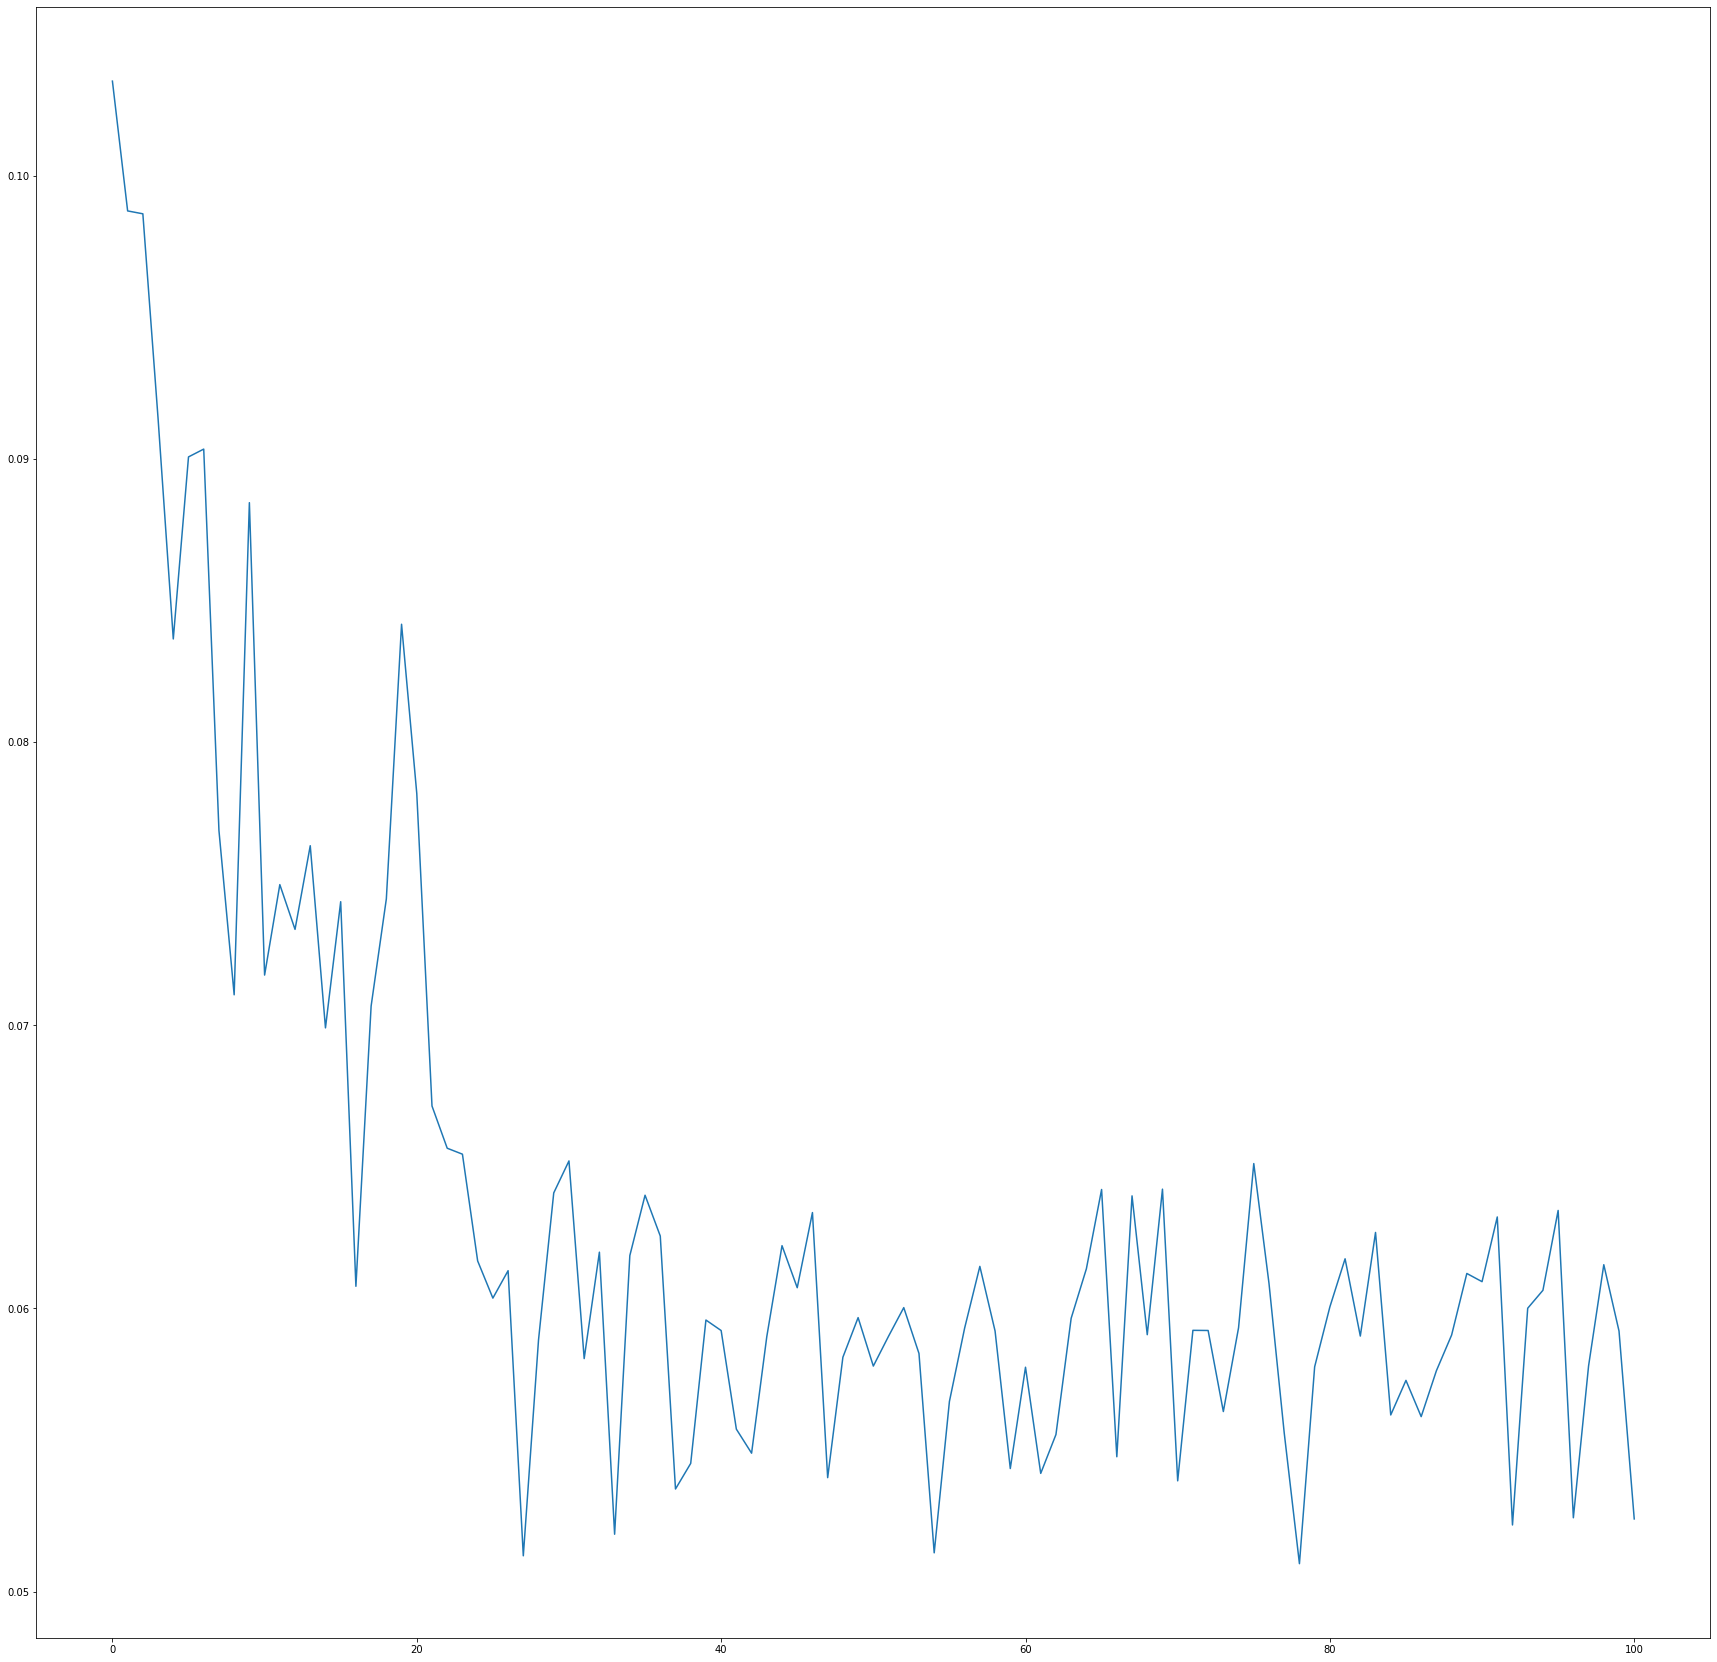

In [32]:
%matplotlib inline
from IPython.display import clear_output
losses=[]
for i,item in enumerate(dataloaderV2):
    if i>100:
        break
    print(i)
    first,second=item
#     first=Variable(first.cuda())
#     second=Variable(seceond.cuda())
    secondObjects=second[:,tupleForEachVehicle,0:6]
    
    output=wholeNet(first)
#     print(output)
    loss=MSELoss(output,secondObjects)
    print(loss)
    losses.append(loss.item())
    optim.zero_grad()
    loss.backward()
    optim.step()
plt.figure(figsize=(30,30))
plt.plot(losses)
plt.show()